In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import time
import copy
from pathlib import Path

# Hyperparameters
CONFIG = {
    'batch_size': 32,
    'num_epochs': 30,
    'learning_rate': 0.001,
    'momentum': 0.9,
    'weight_decay': 1e-4,
    'step_size': 7,
    'gamma': 0.1,
    'num_classes': 102,
    'image_size': 224,
    'num_workers': 4,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}

class Flowers102Trainer:
    def __init__(self, data_dir='flowers102', model_name='resnet50'):
        self.data_dir = Path(data_dir)
        self.model_name = model_name
        self.device = torch.device(CONFIG['device'])

        # Data transforms
        self.data_transforms = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(CONFIG['image_size']),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(15),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
            'val': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(CONFIG['image_size']),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
            'test': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(CONFIG['image_size']),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        }

        self.dataloaders = {}
        self.dataset_sizes = {}
        self.model = None
        self.optimizer = None
        self.scheduler = None
        self.criterion = nn.CrossEntropyLoss()

    def load_data(self):
        """Load Flowers102 dataset"""
        print("Loading datasets...")

        for split in ['train', 'val', 'test']:
            dataset = datasets.Flowers102(
                root=str(self.data_dir),
                split=split,
                transform=self.data_transforms[split],
                download=True
            )

            self.dataloaders[split] = DataLoader(
                dataset,
                batch_size=CONFIG['batch_size'],
                shuffle=(split == 'train'),
                num_workers=CONFIG['num_workers'],
                pin_memory=True
            )
            self.dataset_sizes[split] = len(dataset)

        print(f"Train: {self.dataset_sizes['train']}, Val: {self.dataset_sizes['val']}, Test: {self.dataset_sizes['test']}")

    def build_model(self):
        """Build model with pretrained weights"""
        print(f"Building {self.model_name} model...")

        if self.model_name == 'resnet50':
            self.model = models.resnet50(pretrained=True)
            num_ftrs = self.model.fc.in_features
            self.model.fc = nn.Linear(num_ftrs, CONFIG['num_classes'])

        elif self.model_name == 'efficientnet_b0':
            self.model = models.efficientnet_b0(pretrained=True)
            num_ftrs = self.model.classifier[1].in_features
            self.model.classifier[1] = nn.Linear(num_ftrs, CONFIG['num_classes'])

        elif self.model_name == 'vit_b_16':
            self.model = models.vit_b_16(pretrained=True)
            num_ftrs = self.model.heads.head.in_features
            self.model.heads.head = nn.Linear(num_ftrs, CONFIG['num_classes'])

        self.model = self.model.to(self.device)

        # Optimizer and scheduler
        self.optimizer = optim.SGD(
            self.model.parameters(),
            lr=CONFIG['learning_rate'],
            momentum=CONFIG['momentum'],
            weight_decay=CONFIG['weight_decay']
        )

        self.scheduler = optim.lr_scheduler.StepLR(
            self.optimizer,
            step_size=CONFIG['step_size'],
            gamma=CONFIG['gamma']
        )

    def train_epoch(self):
        """Train for one epoch"""
        self.model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in self.dataloaders['train']:
            inputs = inputs.to(self.device)
            labels = labels.to(self.device)

            self.optimizer.zero_grad()

            outputs = self.model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = self.criterion(outputs, labels)

            loss.backward()
            self.optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / self.dataset_sizes['train']
        epoch_acc = running_corrects.double() / self.dataset_sizes['train']

        return epoch_loss, epoch_acc

    def validate(self, phase='val'):
        """Validate the model"""
        self.model.eval()
        running_loss = 0.0
        running_corrects = 0

        with torch.no_grad():
            for inputs, labels in self.dataloaders[phase]:
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)

                outputs = self.model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = self.criterion(outputs, labels)

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / self.dataset_sizes[phase]
        epoch_acc = running_corrects.double() / self.dataset_sizes[phase]

        return epoch_loss, epoch_acc

    def train(self):
        """Full training loop"""
        print(f"\nStarting training on {self.device}...")
        print(f"Model: {self.model_name}")
        print(f"Epochs: {CONFIG['num_epochs']}, Batch size: {CONFIG['batch_size']}")
        print(f"Learning rate: {CONFIG['learning_rate']}\n")

        best_model_wts = copy.deepcopy(self.model.state_dict())
        best_acc = 0.0

        start_time = time.time()

        for epoch in range(CONFIG['num_epochs']):
            epoch_start = time.time()

            # Train
            train_loss, train_acc = self.train_epoch()

            # Validate
            val_loss, val_acc = self.validate('val')

            # Step scheduler
            self.scheduler.step()

            epoch_time = time.time() - epoch_start

            print(f'Epoch {epoch+1}/{CONFIG["num_epochs"]} ({epoch_time:.0f}s)')
            print(f'  Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}')
            print(f'  Val   Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

            # Save best model
            if val_acc > best_acc:
                best_acc = val_acc
                best_model_wts = copy.deepcopy(self.model.state_dict())
                print(f'  *** New best model! ***')
            print()

        total_time = time.time() - start_time
        print(f'Training complete in {total_time//60:.0f}m {total_time%60:.0f}s')
        print(f'Best val accuracy: {best_acc:.4f}')

        # Load best model weights
        self.model.load_state_dict(best_model_wts)

        # Test on test set
        test_loss, test_acc = self.validate('test')
        print(f'\nTest Loss: {test_loss:.4f} Acc: {test_acc:.4f}')

        return self.model

    def save_model(self, path='flowers102_model.pth'):
        """Save model checkpoint"""
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'model_name': self.model_name,
            'config': CONFIG
        }, path)
        print(f'Model saved to {path}')

    def load_model(self, path='flowers102_model.pth'):
        """Load model checkpoint"""
        checkpoint = torch.load(path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        print(f'Model loaded from {path}')


# Usage example
if __name__ == '__main__':
    # Initialize trainer
    trainer = Flowers102Trainer(model_name='resnet50')

    # Load data
    trainer.load_data()

    # Build model
    trainer.build_model()

    # Train
    model = trainer.train()

    # Save model
    trainer.save_model('flowers102_resnet50.pth')

Loading datasets...


100%|██████████| 345M/345M [00:01<00:00, 187MB/s]
100%|██████████| 502/502 [00:00<00:00, 1.81MB/s]
100%|██████████| 15.0k/15.0k [00:00<00:00, 33.4MB/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 a

Train: 1020, Val: 1020, Test: 6149
Building resnet50 model...
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 186MB/s]



Starting training on cuda...
Model: resnet50
Epochs: 30, Batch size: 32
Learning rate: 0.001

Epoch 1/30 (20s)
  Train Loss: 4.6641 Acc: 0.0176
  Val   Loss: 4.4807 Acc: 0.0480
  *** New best model! ***

Epoch 2/30 (16s)
  Train Loss: 4.4011 Acc: 0.1000
  Val   Loss: 4.1520 Acc: 0.2451
  *** New best model! ***

Epoch 3/30 (18s)
  Train Loss: 4.0866 Acc: 0.3069
  Val   Loss: 3.7103 Acc: 0.4088
  *** New best model! ***

Epoch 4/30 (17s)
  Train Loss: 3.6568 Acc: 0.4912
  Val   Loss: 3.1470 Acc: 0.5569
  *** New best model! ***

Epoch 5/30 (16s)
  Train Loss: 3.2160 Acc: 0.5324
  Val   Loss: 2.6380 Acc: 0.5912
  *** New best model! ***

Epoch 6/30 (18s)
  Train Loss: 2.7847 Acc: 0.6176
  Val   Loss: 2.2383 Acc: 0.6588
  *** New best model! ***

Epoch 7/30 (17s)
  Train Loss: 2.4328 Acc: 0.6667
  Val   Loss: 1.9003 Acc: 0.6980
  *** New best model! ***

Epoch 8/30 (17s)
  Train Loss: 2.2143 Acc: 0.7049
  Val   Loss: 1.8783 Acc: 0.7059
  *** New best model! ***

Epoch 9/30 (18s)
  Train 

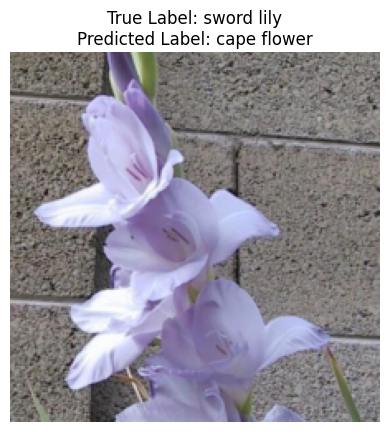

In [22]:
import random
import matplotlib.pyplot as plt
import numpy as np

# Get a random image from the test set
random_index = random.randint(0, len(trainer.dataloaders['test'].dataset) - 1)
random_image, true_label = trainer.dataloaders['test'].dataset[random_index]

# Get the class names from the dataset
class_names = trainer.dataloaders['test'].dataset.classes

# Set the model to evaluation mode
model.eval()

# Make a prediction
with torch.no_grad():
    inputs = random_image.unsqueeze(0).to(CONFIG['device'])
    outputs = model(inputs)
    _, predicted_label_index = torch.max(outputs, 1)
    predicted_label = class_names[predicted_label_index.item()]

# Convert the image tensor to numpy for displaying
image_np = random_image.permute(1, 2, 0).numpy()

# Undo normalization for displaying
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
image_np = std * image_np + mean
image_np = np.clip(image_np, 0, 1)

# Display the image and labels
plt.imshow(image_np)
plt.title(f"True Label: {class_names[true_label]}\nPredicted Label: {predicted_label}")
plt.axis('off')
plt.show()

Displaying 3 images for: sword lily


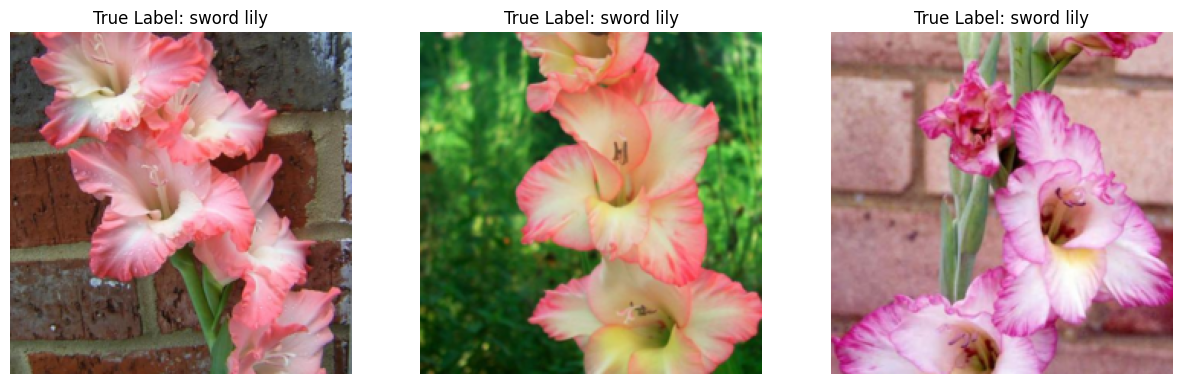

Displaying 3 images for: cape flower


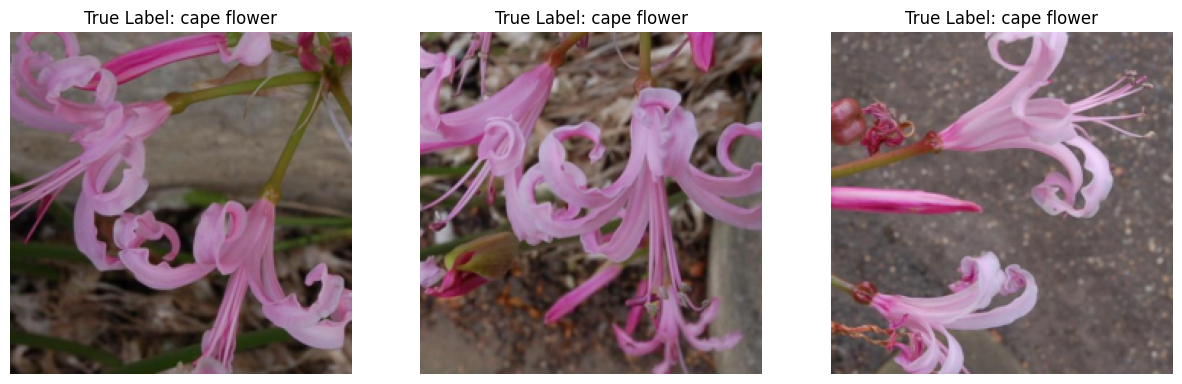

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import random

def display_images_by_label_only(dataset, class_names, labels_to_find, num_images=3):
    """
    Displays images from the dataset for specified labels without prediction.

    Args:
        dataset: The dataset to sample from.
        class_names: A list of class names.
        labels_to_find: A list of strings representing the class names to display.
        num_images: The number of images to display for each label.
    """
    image_indices = {}
    for i in range(len(dataset)):
        _, label = dataset[i]
        class_name = class_names[label]
        if class_name in labels_to_find:
            if class_name not in image_indices:
                image_indices[class_name] = []
            image_indices[class_name].append(i)

    for label in labels_to_find:
        if label in image_indices:
            print(f"Displaying {num_images} images for: {label}")
            selected_indices = random.sample(image_indices[label], min(num_images, len(image_indices[label])))

            plt.figure(figsize=(15, 5))
            for i, index in enumerate(selected_indices):
                image, true_label = dataset[index]

                # Convert the image tensor to numpy for displaying
                image_np = image.permute(1, 2, 0).numpy()

                # Undo normalization for displaying
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                image_np = std * image_np + mean
                image_np = np.clip(image_np, 0, 1)

                plt.subplot(1, num_images, i + 1)
                plt.imshow(image_np)
                plt.title(f"True Label: {class_names[true_label]}")
                plt.axis('off')
            plt.show()
        else:
            print(f"No images found for label: {label}")

# Get the test dataset and class names
test_dataset = trainer.dataloaders['test'].dataset
class_names = test_dataset.classes

# Labels to find
labels_to_find = ["sword lily", "cape flower"]

# Display images
display_images_by_label_only(test_dataset, class_names, labels_to_find)

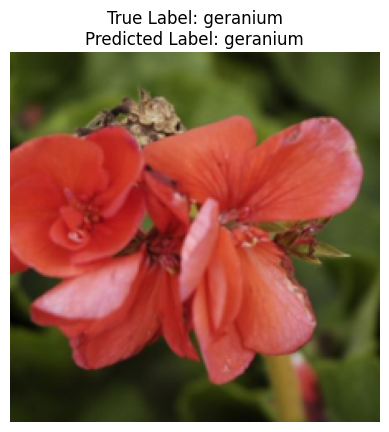

In [29]:
import random
import matplotlib.pyplot as plt
import numpy as np

# Get a random image from the test set
random_index = random.randint(0, len(trainer.dataloaders['test'].dataset) - 1)
random_image, true_label = trainer.dataloaders['test'].dataset[random_index]

# Get the class names from the dataset
class_names = trainer.dataloaders['test'].dataset.classes

# Set the model to evaluation mode
model.eval()

# Make a prediction
with torch.no_grad():
    inputs = random_image.unsqueeze(0).to(CONFIG['device'])
    outputs = model(inputs)
    _, predicted_label_index = torch.max(outputs, 1)
    predicted_label = class_names[predicted_label_index.item()]

# Convert the image tensor to numpy for displaying
image_np = random_image.permute(1, 2, 0).numpy()

# Undo normalization for displaying
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
image_np = std * image_np + mean
image_np = np.clip(image_np, 0, 1)

# Display the image and labels
plt.imshow(image_np)
plt.title(f"True Label: {class_names[true_label]}\nPredicted Label: {predicted_label}")
plt.axis('off')
plt.show()